In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

## additional packages in this chapter
import spacy
import nltk

## functions used in this chapter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import LatentDirichletAllocation

## data and data paths
from sklearn.datasets import load_files

## REMINDER: LogisticRegression() parameter change
## Changed in version 0.22: The default solver changed from ‘liblinear’ to ‘lbfgs’ in 0.22.
## have to enter: solver='liblinear' in the model "()"

## REMINDER: SVC() parameter change
## Changed in version 0.22: The default value of gamma changed 
## from ‘auto’ to ‘scale’.
## have to enter: gamma='auto' in the model "()"

## warning noted that the ".scorer" is depricated in this version and 
## import without it, i.e. "from sklearn.metrics import SCORERS"

import time
a= time.time()
## record time to run the job and print it
b= time.time()
print("Run time: {:.4f}".format(b-a))
## EXPLORE: using timeit() instead

Run time: 0.0000


In [2]:
# DO MORE RESERACH ON THIS CODE AND WHY I CAN'T RUN IT
## alternatively tried this code from online searches, also didn;t work
## ! wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data\n
## ! tar xzf data/aclImdb_v1.tar.gz --skip-old-files -C data

## Section 2: Example Application: Sentiment Analysis of Movie Reviews
## In-1, pg 328
## PER JOSH.. code written for unix not windows (?)

# !tree -dL 2 aclImdb

## In-2, pg 328
## this deletes the unsup folder. I did it manually
##!rm -r data/aclImdb/train/unsup

In [3]:
## In-3, pg 328
## if you put the full file path, no matter what active folder you're in it will work
## can either use / or and r before and \ separators

import time
a= time.time()

from sklearn.datasets import load_files

reviews_train = load_files("aclImdb/train")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

b= time.time()
print("Run time: {:.4f}".format((b-a)/60))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."
Run time: 2.5067


In [4]:
## In-4, pg 329
## You can also see that the review contains some HTML line breaks (<br />).
## While these are unlikely to have a large impact on our machine learning 
## models, it is better to clean the data and remove this formatting before we proceed:

text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [5]:
## In-5, pg 329

print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


In [6]:
## In-6, pg 329
import time
a= time.time()

reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Number of documents in test data: 25000
Samples per class (test): [12500 12500]
Run time: 2.5302 min


In [7]:
## Section 3: Representing Text Data as a Bag of Words
## In-7, pg 331
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [8]:
## In-8, pg 331
##import and instantiate the CountVectorizer and fit it to our toy data
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
## In-9, pg 331
## Fitting the CountVectorizer consists of the tokenization of the training 
## data and building of the vocabulary, which we can access as the 
## vocabulary_ attribute:

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [10]:
## In-10, pg 331
## To create the bag-of-words representation for the training data, 
## we call the transform method:

bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [11]:
## In-11, pg 332

## To look at the actual content of the sparse matrix, we can convert it 
## to a “dense” NumPy array (that also stores all the 0 entries) using the 
## toarray method:

print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


In [12]:
## In-12, pg 333

vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [13]:
## In-13, pg 333

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [14]:
## In-14, pg 334
## we violate our lesson from Chapter 6 on cross-validation with 
## preprocessing here. Using the default settings of CountVectorizer, 
## it actually does not collect any statistics, so our results are valid. 
## Using Pipeline from the start would be a better choice for applications, 
## but we defer it for ease of exposure.

## changed solver to match book version default and added max_iter

import time
a= time.time()

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(solver='liblinear',max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

## record time to run the job and print it
b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Mean cross-validation accuracy: 0.88
Run time: 0.6271 min


In [15]:
## In-15, pg 334
## changed solver to match book version default and added max_iter

a= time.time()

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='liblinear',max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

## record time to run the job and print it
b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}
Run time: 2.3236 min


In [16]:
## In-16, pg 335
## We can now assess the generalization performance of this parameter
## setting on the test set

a= time.time()

X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Test score: 0.88
Run time: 0.1645 min


In [17]:
## In-17, pg 335
## We can set the minimum number of documents a token needs to appear in
## with the min_df parameter:

a= time.time()

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>
Run time: 0.3203 min


In [18]:
## In-18, pg 335

a= time.time()

feature_names = vect.get_feature_names()
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [19]:
## In-19, pg 336

## changed solver to match book version default and added max_iter

a= time.time()

grid = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=100), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Best cross-validation score: 0.89
Run time: 2.2191 min


In [20]:
## Section 4: Stopwords
## In-20, pg 337

a= time.time()

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## get different words than in the book, but same number of words... list 
## might have slightly changed.. or thery're ordered differently..

Number of stop words: 318
Every 10th stopword:
['can', 'below', 'those', 'fifteen', 'your', 'a', 'as', 'without', 'than', 'within', 'neither', 'something', 'so', 'do', 'which', 'co', 'sometime', 'what', 'per', 'he', 'whoever', 'thence', 'hasnt', 'ourselves', 'somewhere', 'beside', 'after', 'nevertheless', 'done', 'last', 'get', 'my']
Run time: 0.0000 min


In [21]:
## In-21, pg 337

a= time.time()

# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>
Run time: 0.1954 min


In [22]:
## In-22, pg 337

## changed solver to match book version default and added max_iter

a= time.time()

grid = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Best cross-validation score: 0.88
Run time: 0.7743 min


In [23]:
## Section 5: Rescaling the data using tf-idf
## In-23, pg 339

## changed solver to match book version default and added max_iter

a= time.time()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression(solver='liblinear', max_iter=100))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Best cross-validation score: 0.89
Run time: 3.0715 min


In [24]:
## In-24, pg 339

a= time.time()

vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## words are likely ordered differently versus the book, thus different output

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
Features with highest tfidf: 
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']
Run time: 0.1032 min


In [25]:
## In-25, pg 340
## find the words that have low inverse document frequency—that is, those
## that appear frequently and are therefore deemed less important. The 
## inverse document frequency values found on the training set are stored in the idf_ attribute:

a= time.time()

sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
feature_names[sorted_by_idf[:100]]))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## same words as the book, because we did a sort!

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']
Run time: 0.0001 min


Run time: 0.0029 min


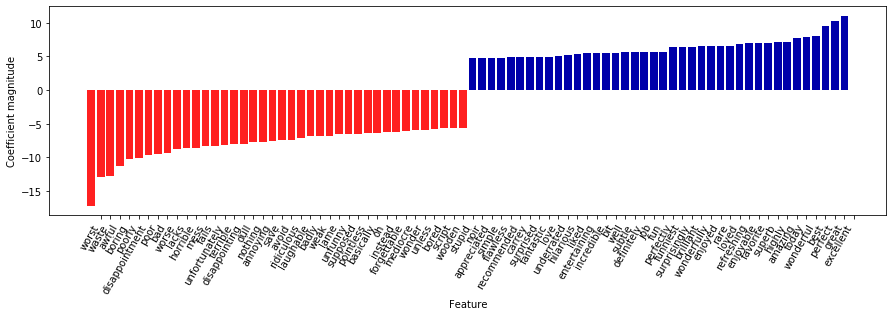

In [26]:
## Section 6: Investigating Model Coefficients
## In-26, pg 337
## look at the largest coefficients, and see which words these correspond to

a= time.time()

mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## Figure 7-2. Largest and smallest coefficients of logistic regression 
## trained on tf-idf features
## The negative coefficients on the left belong to words that according 
## to the model are indicative of negative reviews, while the positive 
## coefficients on the right belong to words that according to the model
## indicate positive reviews.

In [27]:
## Section 7: Bag-of-Words with More Than One Word (n-Grams)
## In-27, pg 342

a= time.time()

print("bards_words:\n{}".format(bards_words))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']
Run time: 0.0001 min


In [28]:
## In-28, pg 342

a= time.time()

cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']
Run time: 0.0000 min


In [29]:
## In-29, pg 342

a= time.time()

cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']
Run time: 0.0000 min


In [30]:
## In-30, pg 343

a= time.time()

print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]
Run time: 0.0000 min


In [31]:
## In-31, pg 343
## using unigrams, bigrams, and trigrams on bards_words

a= time.time()

cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']
Run time: 0.0000 min


In [32]:
## In-32, pg 343

## changed solver to match book version default and added max_iter

a= time.time()

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(solver='liblinear', max_iter=25))
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
Run time: 43.6423 min


Run time: 0.0010 min


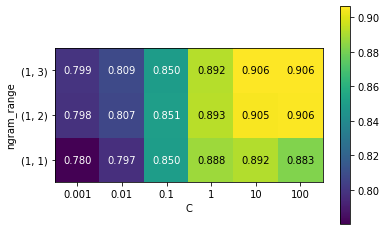

In [33]:
## In-33, pg 344

a= time.time()

# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.0145 min


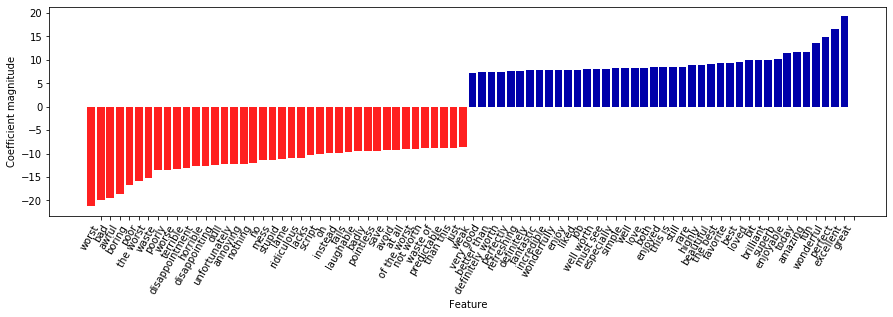

In [34]:
## In-34, pg 345

a= time.time()

# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## Figure 7-4. Most important features when using unigrams, bigrams, 
## and trigrams with tf-idf rescaling

Run time: 0.0057 min


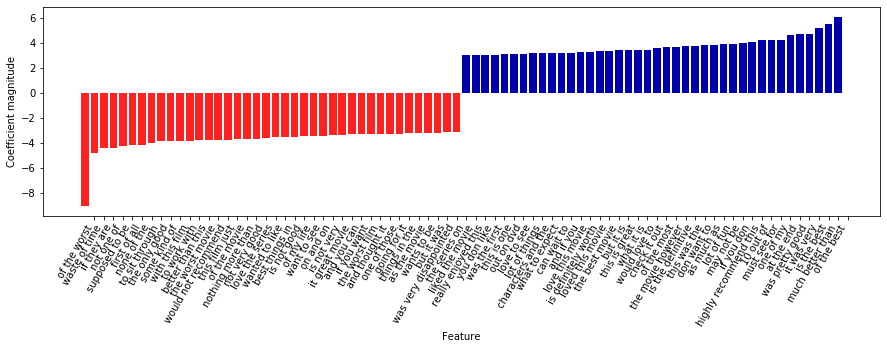

In [35]:
## In-35, pg 345

a= time.time()

# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## Figure 7-5. Visualization of only the important trigram features of the model

In [36]:
## Section 8: Advanced Tokenization, Stemming, and Lemmatization
## In-36, pg 347

## changed line ""en_nlp = spacy.load('en')"" to """en_nlp = spacy.load('en_core_web_sm')""

a= time.time()

import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load('en_core_web_sm')
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.0509 min


In [37]:
## In-37, pg 347

a= time.time()

compare_normalization(u"Our meeting today was worse than yesterday, "
                      "I'm scared of meeting the clients tomorrow.")

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Run time: 0.0009 min


In [38]:
## In-38, pg 348
## We can use the lemmatization from spacy to create a
## callable that will take a string and produce a list of lemmas:

## changed line ""en_nlp = spacy.load('en')"" to """en_nlp = spacy.load('en_core_web_sm')""
## removed "entity=False, parse=False" from "doc_spacy = en_nlp(document, entity=False, parse=False)""

a= time.time()

# Technicality: we want to use the regexp-based tokenizer
# that is used by CountVectorizer and only use the lemmatization
# from spacy. To this end, we replace en_nlp.tokenizer (the spacy tokenizer)
# with the regexp-based tokenization.
import re
# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer
en_nlp = spacy.load('en_core_web_sm')
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.0199 min


In [39]:
## In-39, pg 348
## transform the data and inspect the vocabulary size

a= time.time()

# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## As you can see from the output, lemmatization reduced the number of 
## features from 27,271 (with the standard CountVectorizer processing) to 21,596.

## I get different lemma shape (X_train_lemma.shape: (25000, 21825)) than the book (X_train_lemma.shape: (25000, 21596))

C:\Users\MainUser\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: [W002] Tokenizer.from_list is now deprecated. Create a new Doc object instead and pass in the strings as the `words` keyword argument, for example:
from spacy.tokens import Doc
doc = Doc(nlp.vocab, words=[...])


X_train_lemma.shape: (25000, 21825)
X_train.shape: (25000, 27271)
Run time: 16.0281 min


In [40]:
## In-40, pg 349
## To illustrate how lemmatization can help, we will use StratifiedShuffleSplit 
## for cross-validation, using only 1% of the data as training data and 
## the rest as test data:

## changed solver to match book version default and added max_iter

a= time.time()

# build a grid search using only 1% of the data as the training set
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=100), param_grid, cv=cv)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# perform grid search with lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## I get different Best cross-validation score (lemmatization): 0.735 than the book (0.731)

Best cross-validation score (standard CountVectorizer): 0.721
Best cross-validation score (lemmatization): 0.735
Run time: 0.3009 min


In [41]:
## Section 9: Topic Modeling and Document Clustering
## In-41, pg 350

## We’ll remove words that appear in at least 15 percent of the documents,
## and we’ll limit the bag-of-words model to the 10,000 words that are most
## common after removing the top 15 percent:

a= time.time()

vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.1088 min


In [44]:
## In-42, pg 351

a= time.time()

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
max_iter=25, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 15.4635 min


In [45]:
## In-43, pg 351
## components_ attribute  stores how important each word is for each topic.
## The size of components_ is (n_topics = n_components, n_words):

a= time.time()

print("lda.components_.shape: {}".format(lda.components_.shape))

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

lda.components_.shape: (10, 10000)
Run time: 0.0000 min


In [46]:
## In-44, pg 351
## To understand better what the different topics mean, we will look at 
## the most important words for each of the topics. The print_topics 
## function provides a nice formatting for these features

a= time.time()

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.0007 min


In [47]:
## In-45, pg 351

a= time.time()

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [50]:
## In-46, pg 352
## Next, we will learn another model, this time with 100 topics. 
## Using more topics makes the analysis much harder, but makes it more 
## likely that topics can specialize to interesting subsets of the data:

a= time.time()

lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 16.0198 min


In [51]:
## In-47, pg 353

a= time.time()

topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          
performances  waste         cowboy        away          each          
dark          pretty        jewish        head          french        
twist 

In [52]:
## In-48, pg 354

a= time.time()

# sort by weight of "music" topic 45
music = np.argsort(document_topics100[:, 45])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

Run time: 0.0079 min


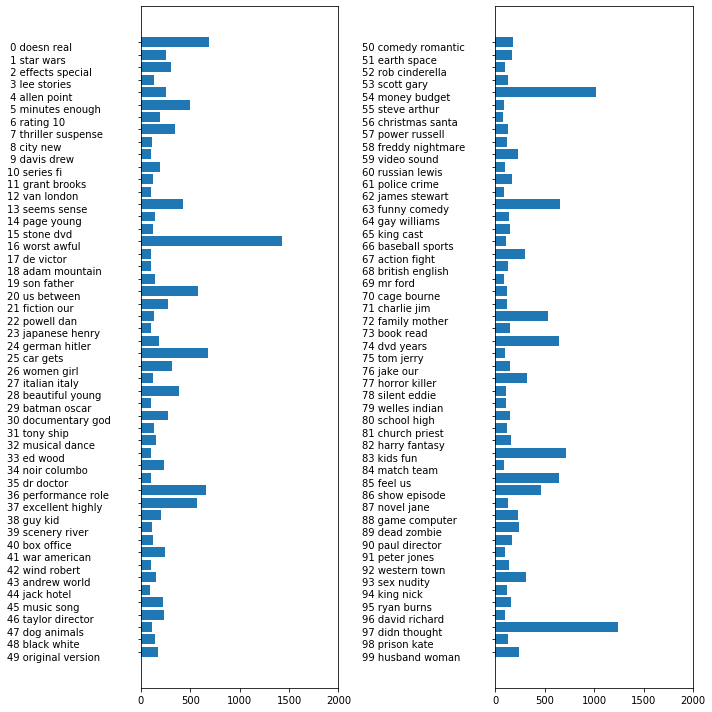

In [53]:
## In-49, pg 355
## Another interesting way to inspect the topics is to see how much weight 
## each topic gets overall, by summing the document_topics over all reviews.
## name each topic by theMtwo most common words.

a= time.time()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

## Figure 7-6. Topic weights learned by LDA

In [55]:
## In-38, pg 348

a= time.time()


b= time.time()
print("Run time: {:.4f} min".format((b-a)/60))

Run time: 0.0000 min
